# DNN 모델

- 미리 정리된 학습데이터를 사용
- cross validation 적용
- dnn 적용
- ensemble 적용

In [1]:
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import KFold
import time
import matplotlib.pyplot as plt

/home/shkim/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
class Model:

    def __init__(self, sess, name):
        self.sess = sess
        self.name = name
        self._build_net()

    def _build_net(self):
        with tf.variable_scope(self.name):
            # dropout (keep_prob) rate  0.7~0.5 on training, but should be 1
            # for testing
            self.training = tf.placeholder(tf.bool)

            # input place holders
            self.X = tf.placeholder(tf.float32, [None, 8])
            self.Y = tf.placeholder(tf.float32, [None, 1])
            
            initializer = tf.contrib.layers.xavier_initializer()
            dense1 = tf.layers.dense(inputs=self.X, units=100, activation=tf.nn.relu, kernel_initializer=initializer)
            dropout1 = tf.layers.dropout(inputs=dense1, rate=0.5, training=self.training)
            
            dense2 = tf.layers.dense(inputs=dropout1, units=100, activation=tf.nn.relu, kernel_initializer=initializer)
            dropout2 = tf.layers.dropout(inputs=dense2, rate=0.5, training=self.training)
            
            dense3 = tf.layers.dense(inputs=dropout2, units=100, activation=tf.nn.relu, kernel_initializer=initializer)
            dropout3 = tf.layers.dropout(inputs=dense3, rate=0.5, training=self.training)
            
            dense4 = tf.layers.dense(inputs=dropout3, units=100, activation=tf.nn.relu, kernel_initializer=initializer)
            dropout4 = tf.layers.dropout(inputs=dense4, rate=0.5, training=self.training)

            # Logits (no activation) Layer: L5 Final FC 625 inputs -> 10 outputs
            self.logits = tf.layers.dense(inputs=dropout4, units=1)
        
        # define cost/loss & optimizer
        self.cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=self.logits, labels=self.Y))
        self.optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(self.cost)

        self.prediction = tf.round(tf.nn.sigmoid(self.logits))
        correct_prediction = tf.equal(self.prediction, self.Y)
        self.correct_count = tf.reduce_sum(tf.cast(correct_prediction, tf.float32))
        self.accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    def predict(self, x_test, training=False):
        return self.sess.run(self.prediction, feed_dict={self.X: x_test, self.training: training})

    def get_accuracy(self, x_test, y_test, training=False):
        return self.sess.run(self.accuracy, feed_dict={self.X: x_test, self.Y: y_test, self.training: training})
    
    def get_accuracy2(self, x_test, y_test, training=False):
        batch_size = 100 
        total_train_rows = y_test.shape[0]
        total_batch = int(total_train_rows / batch_size)
        total_correct_count = 0;
        for i in range(total_batch):
                begin = i * batch_size
                end = begin + batch_size
                batch_xs = train_x[begin : end].values # pandas 데이터에서 values로 값을 가져온다.
                batch_ys = train_y_onehot[begin : end].values
                cur_count = sess.run(self.correct_count, feed_dict={self.X: batch_xs, self.Y: batch_ys, self.training: training})
                total_correct_count += cur_count
        
        accuracy = total_correct_count / total_train_rows
        return accuracy

    def train(self, x_data, y_data, training=True):
        return self.sess.run([self.cost, self.optimizer], feed_dict={self.X: x_data, self.Y: y_data, self.training: training})

In [3]:
train = pd.read_csv('train_01.csv')
train.head()

,Survived,Pclass,Sex,Age,Fare,Cabin,Embarked,Title,FamilySize
0,0,3,0,1.0,0.0,2.0,0,0,0.4
1,1,1,1,3.0,2.0,0.8,1,2,0.4
2,1,3,1,1.0,0.0,2.0,0,1,0.0
3,1,1,1,2.0,2.0,0.8,0,2,0.4
4,0,3,0,2.0,0.0,2.0,0,0,0.0


In [4]:
k_fold = KFold(10)

In [5]:
train_y = train['Survived']
train_x = train.drop('Survived', axis=1)

In [6]:
train_y.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

In [7]:
type(train_y)

pandas.core.series.Series

In [8]:
train_x.head()

,Pclass,Sex,Age,Fare,Cabin,Embarked,Title,FamilySize
0,3,0,1.0,0.0,2.0,0,0,0.4
1,1,1,3.0,2.0,0.8,1,2,0.4
2,3,1,1.0,0.0,2.0,0,1,0.0
3,1,1,2.0,2.0,0.8,0,2,0.4
4,3,0,2.0,0.0,2.0,0,0,0.0


In [9]:
# hyper parameters
learning_rate = 0.001
training_epochs = 1000
batch_size = 100

sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

In [10]:

model = Model(sess, "model")


Instructions for updating:
Use the retry module or similar alternatives.


In [24]:
start_time = time.time()

x_collect = []
train_loss_collect = []
train_acc_collect = []
valid_loss_collect = []
valid_acc_collect = []

iter = 0
sess.run(tf.global_variables_initializer())
for train_indices, valid_indices in k_fold.split(train):
    #print('Train: %s \n| test: %s\n' % (train_indices, test_indices))
    start_time_k = time.time()
    X_train = train_x.iloc[train_indices]
    Y_train = train_y.iloc[train_indices]
    X_valid = train_x.iloc[valid_indices]
    Y_valid = train_y.iloc[valid_indices]
    Y_train_=Y_train.values.reshape([-1,1])
    Y_valid_ = Y_valid.values.reshape([-1,1])
    for i in range(training_epochs):
        c, _ = model.train(X_train.values, Y_train_)
        accuracy_t = model.get_accuracy(X_train.values, Y_train_)
        accuracy_v = model.get_accuracy(X_valid.values, Y_valid_)
        train_acc_collect.append(accuracy_t)
        valid_acc_collect.append(accuracy_v)
        x_collect.append(iter)
        iter=iter+1

    accuracy = model.get_accuracy(X_valid.values, Y_valid_)
    print("accuracy=%.2f" % accuracy, " %.2f seconds" % (time.time() - start_time_k))

print(" %.2f seconds" % (time.time() - start_time))

accuracy=0.79  4.74 seconds
accuracy=0.83  4.84 seconds
accuracy=0.78  4.79 seconds
accuracy=0.85  4.58 seconds
accuracy=0.87  4.61 seconds
accuracy=0.91  4.36 seconds
accuracy=0.85  4.47 seconds
accuracy=0.88  4.62 seconds
accuracy=0.88  4.42 seconds
accuracy=0.89  4.47 seconds
 45.98 seconds


In [25]:
accuracy = model.get_accuracy(train_x.values, train_y.values.reshape([-1,1]))
print("accuracy=%.2f" % accuracy)

accuracy=0.89


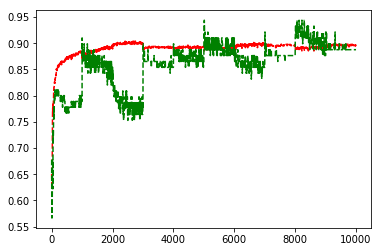

In [27]:
plt.plot(x_collect, train_acc_collect, "r--")
plt.plot(x_collect, valid_acc_collect, "g--")
plt.show()

In [ ]:
test = pd.read_csv("test_01.csv")
test.head()

In [ ]:
test_x = test.drop("PassengerId", axis=1)
test_x.head()

In [ ]:
result = model.predict(test_x.values)
result = result.reshape([-1])
result = result.astype(int)

In [ ]:
submission = pd.DataFrame({"PassengerId": test["PassengerId"], "Survived":result})
submission.head()

In [ ]:
submission.to_csv('submission.csv', index=False)